In [1]:
#importing packages
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
from sklearn.model_selection import GridSearchCV
sns.set()

In [2]:
#Obtain list of S&100 companies from wikipedia
resp = requests.get("https://en.wikipedia.org/wiki/S%26P_100")
convert_soup = bs.BeautifulSoup(resp.text, 'lxml')
table = convert_soup.find('table',{'class':'wikitable sortable'})

tickers = []

for rows in table.findAll('tr')[1:]:
    ticker = rows.findAll('td')[0].text.strip()
    tickers.append(ticker)

all_data = pd.DataFrame()
test_data = pd.DataFrame()
no_data = []

In [3]:
#Extract data from Yahoo Finance
for i in tickers:
    try:
        print(i)
        test_data = pdr.get_data_yahoo(i, start = dt.datetime(1990,1,1), end = dt.date.today())
        test_data['symbol'] = i
        all_data = all_data.append(test_data)
        clear_output(wait = True)
    except:
        no_data.append(i)

    clear_output(wait = True)
print(dt.date.today())
print(all_data.tail(20))

2021-02-26
                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-01-29  46.040001  44.509998  45.549999  44.840000  38950400.0  44.091232   
2021-02-01  45.580002  44.290001  45.580002  44.919998  24412400.0  44.169895   
2021-02-02  46.990002  45.279999  45.810001  45.630001  31940400.0  44.868042   
2021-02-03  47.669998  45.419998  45.630001  47.419998  28459300.0  46.628147   
2021-02-04  48.380001  47.250000  47.880001  48.330002  25280300.0  47.522957   
2021-02-05  50.119999  49.040001  49.180000  49.950001  34951900.0  49.115902   
2021-02-08  52.360001  50.709999  50.919998  52.099998  36998700.0  51.230000   
2021-02-09  50.959999  49.770000  50.669998  50.630001  28977000.0  50.630001   
2021-02-10  51.419998  50.389999  50.630001  51.119999  25723800.0  51.119999   
2021-02-11  50.930000  48.779999  50.889999  49.840000  26946600.0  49.840000   
2021-02-12  50.70

In [4]:
#Creating Return column
all_data['return'] = all_data.groupby('symbol')['Close'].pct_change() 

In [5]:
all_data['SMA_5'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 5).mean())
all_data['SMA_15'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window = 15).mean())
all_data['SMA_ratio'] = all_data['SMA_15'] / all_data['SMA_5']
print(all_data.tail(20))

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-01-29  46.040001  44.509998  45.549999  44.840000  38950400.0  44.091232   
2021-02-01  45.580002  44.290001  45.580002  44.919998  24412400.0  44.169895   
2021-02-02  46.990002  45.279999  45.810001  45.630001  31940400.0  44.868042   
2021-02-03  47.669998  45.419998  45.630001  47.419998  28459300.0  46.628147   
2021-02-04  48.380001  47.250000  47.880001  48.330002  25280300.0  47.522957   
2021-02-05  50.119999  49.040001  49.180000  49.950001  34951900.0  49.115902   
2021-02-08  52.360001  50.709999  50.919998  52.099998  36998700.0  51.230000   
2021-02-09  50.959999  49.770000  50.669998  50.630001  28977000.0  50.630001   
2021-02-10  51.419998  50.389999  50.630001  51.119999  25723800.0  51.119999   
2021-02-11  50.930000  48.779999  50.889999  49.840000  26946600.0  49.840000   
2021-02-12  50.709999  49.41

In [6]:
all_data['SMA5_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 5).mean())
all_data['SMA15_Volume'] = all_data.groupby('symbol')['Volume'].transform(lambda x: x.rolling(window = 15).mean())
all_data['SMA_Volume_Ratio'] = all_data['SMA5_Volume']/all_data['SMA15_Volume']
print(all_data.tail(20))

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-01-29  46.040001  44.509998  45.549999  44.840000  38950400.0  44.091232   
2021-02-01  45.580002  44.290001  45.580002  44.919998  24412400.0  44.169895   
2021-02-02  46.990002  45.279999  45.810001  45.630001  31940400.0  44.868042   
2021-02-03  47.669998  45.419998  45.630001  47.419998  28459300.0  46.628147   
2021-02-04  48.380001  47.250000  47.880001  48.330002  25280300.0  47.522957   
2021-02-05  50.119999  49.040001  49.180000  49.950001  34951900.0  49.115902   
2021-02-08  52.360001  50.709999  50.919998  52.099998  36998700.0  51.230000   
2021-02-09  50.959999  49.770000  50.669998  50.630001  28977000.0  50.630001   
2021-02-10  51.419998  50.389999  50.630001  51.119999  25723800.0  51.119999   
2021-02-11  50.930000  48.779999  50.889999  49.840000  26946600.0  49.840000   
2021-02-12  50.709999  49.41

In [7]:
def Wilder(data, periods):
    start = np.where(~np.isnan(data))[0][0] #Check if nans present in beginning
    Wilder = np.array([np.nan]*len(data))
    Wilder[start+periods-1] = data[start:(start+periods)].mean() #Simple Moving Average
    for i in range(start+periods,len(data)):
        Wilder[i] = (Wilder[i-1]*(periods-1) + data[i])/periods #Wilder Smoothing
    return(Wilder)
print(all_data.tail(20))

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-01-29  46.040001  44.509998  45.549999  44.840000  38950400.0  44.091232   
2021-02-01  45.580002  44.290001  45.580002  44.919998  24412400.0  44.169895   
2021-02-02  46.990002  45.279999  45.810001  45.630001  31940400.0  44.868042   
2021-02-03  47.669998  45.419998  45.630001  47.419998  28459300.0  46.628147   
2021-02-04  48.380001  47.250000  47.880001  48.330002  25280300.0  47.522957   
2021-02-05  50.119999  49.040001  49.180000  49.950001  34951900.0  49.115902   
2021-02-08  52.360001  50.709999  50.919998  52.099998  36998700.0  51.230000   
2021-02-09  50.959999  49.770000  50.669998  50.630001  28977000.0  50.630001   
2021-02-10  51.419998  50.389999  50.630001  51.119999  25723800.0  51.119999   
2021-02-11  50.930000  48.779999  50.889999  49.840000  26946600.0  49.840000   
2021-02-12  50.709999  49.41

In [8]:
all_data['prev_close'] = all_data.groupby('symbol')['Close'].shift(1)
all_data['TR'] = np.maximum((all_data['High'] - all_data['Low']), 
                     np.maximum(abs(all_data['High'] - all_data['prev_close']), 
                     abs(all_data['prev_close'] - all_data['Low'])))
for i in all_data['symbol'].unique():
    TR_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ATR_5'] = Wilder(TR_data['TR'], 5)
    all_data.loc[all_data.symbol==i,'ATR_15'] = Wilder(TR_data['TR'], 15)

all_data['ATR_Ratio'] = all_data['ATR_5'] / all_data['ATR_15']
print(all_data.tail(20))

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-01-29  46.040001  44.509998  45.549999  44.840000  38950400.0  44.091232   
2021-02-01  45.580002  44.290001  45.580002  44.919998  24412400.0  44.169895   
2021-02-02  46.990002  45.279999  45.810001  45.630001  31940400.0  44.868042   
2021-02-03  47.669998  45.419998  45.630001  47.419998  28459300.0  46.628147   
2021-02-04  48.380001  47.250000  47.880001  48.330002  25280300.0  47.522957   
2021-02-05  50.119999  49.040001  49.180000  49.950001  34951900.0  49.115902   
2021-02-08  52.360001  50.709999  50.919998  52.099998  36998700.0  51.230000   
2021-02-09  50.959999  49.770000  50.669998  50.630001  28977000.0  50.630001   
2021-02-10  51.419998  50.389999  50.630001  51.119999  25723800.0  51.119999   
2021-02-11  50.930000  48.779999  50.889999  49.840000  26946600.0  49.840000   
2021-02-12  50.709999  49.41

In [9]:
all_data['prev_high'] = all_data.groupby('symbol')['High'].shift(1)
all_data['prev_low'] = all_data.groupby('symbol')['Low'].shift(1)

all_data['+DM'] = np.where(~np.isnan(all_data.prev_high),
                           np.where((all_data['High'] > all_data['prev_high']) & 
         (((all_data['High'] - all_data['prev_high']) > (all_data['prev_low'] - all_data['Low']))), 
                                                                  all_data['High'] - all_data['prev_high'], 
                                                                  0),np.nan)

all_data['-DM'] = np.where(~np.isnan(all_data.prev_low),
                           np.where((all_data['prev_low'] > all_data['Low']) & 
         (((all_data['prev_low'] - all_data['Low']) > (all_data['High'] - all_data['prev_high']))), 
                                    all_data['prev_low'] - all_data['Low'], 
                                    0),np.nan)

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'+DM_5'] = Wilder(ADX_data['+DM'], 5)
    all_data.loc[all_data.symbol==i,'-DM_5'] = Wilder(ADX_data['-DM'], 5)
    all_data.loc[all_data.symbol==i,'+DM_15'] = Wilder(ADX_data['+DM'], 15)
    all_data.loc[all_data.symbol==i,'-DM_15'] = Wilder(ADX_data['-DM'], 15)

all_data['+DI_5'] = (all_data['+DM_5']/all_data['ATR_5'])*100
all_data['-DI_5'] = (all_data['-DM_5']/all_data['ATR_5'])*100
all_data['+DI_15'] = (all_data['+DM_15']/all_data['ATR_15'])*100
all_data['-DI_15'] = (all_data['-DM_15']/all_data['ATR_15'])*100

all_data['DX_5'] = (np.round(abs(all_data['+DI_5'] - all_data['-DI_5'])/(all_data['+DI_5'] + all_data['-DI_5']) * 100))

all_data['DX_15'] = (np.round(abs(all_data['+DI_15'] - all_data['-DI_15'])/(all_data['+DI_15'] + all_data['-DI_15']) * 100))

for i in all_data['symbol'].unique():
    ADX_data = all_data[all_data.symbol == i].copy()
    all_data.loc[all_data.symbol==i,'ADX_5'] = Wilder(ADX_data['DX_5'], 5)
    all_data.loc[all_data.symbol==i,'ADX_15'] = Wilder(ADX_data['DX_15'], 15)

print(all_data.tail(20))

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-01-29  46.040001  44.509998  45.549999  44.840000  38950400.0  44.091232   
2021-02-01  45.580002  44.290001  45.580002  44.919998  24412400.0  44.169895   
2021-02-02  46.990002  45.279999  45.810001  45.630001  31940400.0  44.868042   
2021-02-03  47.669998  45.419998  45.630001  47.419998  28459300.0  46.628147   
2021-02-04  48.380001  47.250000  47.880001  48.330002  25280300.0  47.522957   
2021-02-05  50.119999  49.040001  49.180000  49.950001  34951900.0  49.115902   
2021-02-08  52.360001  50.709999  50.919998  52.099998  36998700.0  51.230000   
2021-02-09  50.959999  49.770000  50.669998  50.630001  28977000.0  50.630001   
2021-02-10  51.419998  50.389999  50.630001  51.119999  25723800.0  51.119999   
2021-02-11  50.930000  48.779999  50.889999  49.840000  26946600.0  49.840000   
2021-02-12  50.709999  49.41

In [10]:
all_data['Lowest_5D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 5).min())
all_data['High_5D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 5).max())
all_data['Lowest_15D'] = all_data.groupby('symbol')['Low'].transform(lambda x: x.rolling(window = 15).min())
all_data['High_15D'] = all_data.groupby('symbol')['High'].transform(lambda x: x.rolling(window = 15).max())

all_data['Stochastic_5'] = ((all_data['Close'] - all_data['Lowest_5D'])/(all_data['High_5D'] - all_data['Lowest_5D']))*100
all_data['Stochastic_15'] = ((all_data['Close'] - all_data['Lowest_15D'])/(all_data['High_15D'] - all_data['Lowest_15D']))*100

all_data['Stochastic_%D_5'] = all_data['Stochastic_5'].rolling(window = 5).mean()
all_data['Stochastic_%D_15'] = all_data['Stochastic_5'].rolling(window = 15).mean()

all_data['Stochastic_Ratio'] = all_data['Stochastic_%D_5']/all_data['Stochastic_%D_15']
print(all_data.tail(20))

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-01-29  46.040001  44.509998  45.549999  44.840000  38950400.0  44.091232   
2021-02-01  45.580002  44.290001  45.580002  44.919998  24412400.0  44.169895   
2021-02-02  46.990002  45.279999  45.810001  45.630001  31940400.0  44.868042   
2021-02-03  47.669998  45.419998  45.630001  47.419998  28459300.0  46.628147   
2021-02-04  48.380001  47.250000  47.880001  48.330002  25280300.0  47.522957   
2021-02-05  50.119999  49.040001  49.180000  49.950001  34951900.0  49.115902   
2021-02-08  52.360001  50.709999  50.919998  52.099998  36998700.0  51.230000   
2021-02-09  50.959999  49.770000  50.669998  50.630001  28977000.0  50.630001   
2021-02-10  51.419998  50.389999  50.630001  51.119999  25723800.0  51.119999   
2021-02-11  50.930000  48.779999  50.889999  49.840000  26946600.0  49.840000   
2021-02-12  50.709999  49.41

In [11]:
all_data['Diff'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.diff())
all_data['Up'] = all_data['Diff']
all_data.loc[(all_data['Up']<0), 'Up'] = 0

all_data['Down'] = all_data['Diff']
all_data.loc[(all_data['Down']>0), 'Down'] = 0 
all_data['Down'] = abs(all_data['Down'])

all_data['avg_5up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=5).mean())
all_data['avg_5down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=5).mean())

all_data['avg_15up'] = all_data.groupby('symbol')['Up'].transform(lambda x: x.rolling(window=15).mean())
all_data['avg_15down'] = all_data.groupby('symbol')['Down'].transform(lambda x: x.rolling(window=15).mean())

all_data['RS_5'] = all_data['avg_5up'] / all_data['avg_5down']
all_data['RS_15'] = all_data['avg_15up'] / all_data['avg_15down']

all_data['RSI_5'] = 100 - (100/(1+all_data['RS_5']))
all_data['RSI_15'] = 100 - (100/(1+all_data['RS_15']))

all_data['RSI_ratio'] = all_data['RSI_5']/all_data['RSI_15']

print(all_data.tail(20))

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-01-29  46.040001  44.509998  45.549999  44.840000  38950400.0  44.091232   
2021-02-01  45.580002  44.290001  45.580002  44.919998  24412400.0  44.169895   
2021-02-02  46.990002  45.279999  45.810001  45.630001  31940400.0  44.868042   
2021-02-03  47.669998  45.419998  45.630001  47.419998  28459300.0  46.628147   
2021-02-04  48.380001  47.250000  47.880001  48.330002  25280300.0  47.522957   
2021-02-05  50.119999  49.040001  49.180000  49.950001  34951900.0  49.115902   
2021-02-08  52.360001  50.709999  50.919998  52.099998  36998700.0  51.230000   
2021-02-09  50.959999  49.770000  50.669998  50.630001  28977000.0  50.630001   
2021-02-10  51.419998  50.389999  50.630001  51.119999  25723800.0  51.119999   
2021-02-11  50.930000  48.779999  50.889999  49.840000  26946600.0  49.840000   
2021-02-12  50.709999  49.41

In [12]:
all_data['5Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=5, adjust=False).mean())
all_data['15Ewm'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.ewm(span=15, adjust=False).mean())
all_data['MACD'] = all_data['15Ewm'] - all_data['5Ewm']

print(all_data.tail(20))

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-01-29  46.040001  44.509998  45.549999  44.840000  38950400.0  44.091232   
2021-02-01  45.580002  44.290001  45.580002  44.919998  24412400.0  44.169895   
2021-02-02  46.990002  45.279999  45.810001  45.630001  31940400.0  44.868042   
2021-02-03  47.669998  45.419998  45.630001  47.419998  28459300.0  46.628147   
2021-02-04  48.380001  47.250000  47.880001  48.330002  25280300.0  47.522957   
2021-02-05  50.119999  49.040001  49.180000  49.950001  34951900.0  49.115902   
2021-02-08  52.360001  50.709999  50.919998  52.099998  36998700.0  51.230000   
2021-02-09  50.959999  49.770000  50.669998  50.630001  28977000.0  50.630001   
2021-02-10  51.419998  50.389999  50.630001  51.119999  25723800.0  51.119999   
2021-02-11  50.930000  48.779999  50.889999  49.840000  26946600.0  49.840000   
2021-02-12  50.709999  49.41

In [13]:
all_data['15MA'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).mean())
all_data['SD'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.rolling(window=15).std())
all_data['upperband'] = all_data['15MA'] + 2*all_data['SD']
all_data['lowerband'] = all_data['15MA'] - 2*all_data['SD']

print(all_data.tail(20))

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-01-29  46.040001  44.509998  45.549999  44.840000  38950400.0  44.091232   
2021-02-01  45.580002  44.290001  45.580002  44.919998  24412400.0  44.169895   
2021-02-02  46.990002  45.279999  45.810001  45.630001  31940400.0  44.868042   
2021-02-03  47.669998  45.419998  45.630001  47.419998  28459300.0  46.628147   
2021-02-04  48.380001  47.250000  47.880001  48.330002  25280300.0  47.522957   
2021-02-05  50.119999  49.040001  49.180000  49.950001  34951900.0  49.115902   
2021-02-08  52.360001  50.709999  50.919998  52.099998  36998700.0  51.230000   
2021-02-09  50.959999  49.770000  50.669998  50.630001  28977000.0  50.630001   
2021-02-10  51.419998  50.389999  50.630001  51.119999  25723800.0  51.119999   
2021-02-11  50.930000  48.779999  50.889999  49.840000  26946600.0  49.840000   
2021-02-12  50.709999  49.41

In [14]:
all_data['RC'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.pct_change(periods = 15))

print(all_data.tail(20))

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-01-29  46.040001  44.509998  45.549999  44.840000  38950400.0  44.091232   
2021-02-01  45.580002  44.290001  45.580002  44.919998  24412400.0  44.169895   
2021-02-02  46.990002  45.279999  45.810001  45.630001  31940400.0  44.868042   
2021-02-03  47.669998  45.419998  45.630001  47.419998  28459300.0  46.628147   
2021-02-04  48.380001  47.250000  47.880001  48.330002  25280300.0  47.522957   
2021-02-05  50.119999  49.040001  49.180000  49.950001  34951900.0  49.115902   
2021-02-08  52.360001  50.709999  50.919998  52.099998  36998700.0  51.230000   
2021-02-09  50.959999  49.770000  50.669998  50.630001  28977000.0  50.630001   
2021-02-10  51.419998  50.389999  50.630001  51.119999  25723800.0  51.119999   
2021-02-11  50.930000  48.779999  50.889999  49.840000  26946600.0  49.840000   
2021-02-12  50.709999  49.41

In [15]:
all_data['Close_Shifted'] = all_data.groupby('symbol')['Close'].transform(lambda x: x.shift(0))
all_data['Target'] = ((all_data['Close_Shifted'] - all_data['Open'])/(all_data['Open']) * 100).shift(0)
all_data['Target_Direction'] = np.where(all_data['Target']>0,1,0)
all_data = all_data.dropna().copy()

print(all_data.tail(20))

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-01-29  46.040001  44.509998  45.549999  44.840000  38950400.0  44.091232   
2021-02-01  45.580002  44.290001  45.580002  44.919998  24412400.0  44.169895   
2021-02-02  46.990002  45.279999  45.810001  45.630001  31940400.0  44.868042   
2021-02-03  47.669998  45.419998  45.630001  47.419998  28459300.0  46.628147   
2021-02-04  48.380001  47.250000  47.880001  48.330002  25280300.0  47.522957   
2021-02-05  50.119999  49.040001  49.180000  49.950001  34951900.0  49.115902   
2021-02-08  52.360001  50.709999  50.919998  52.099998  36998700.0  51.230000   
2021-02-09  50.959999  49.770000  50.669998  50.630001  28977000.0  50.630001   
2021-02-10  51.419998  50.389999  50.630001  51.119999  25723800.0  51.119999   
2021-02-11  50.930000  48.779999  50.889999  49.840000  26946600.0  49.840000   
2021-02-12  50.709999  49.41

In [16]:
Target_variables = ['SMA_ratio','ATR_5','ATR_15','ATR_Ratio',
                       'ADX_5','ADX_15','SMA_Volume_Ratio','Stochastic_5','Stochastic_15','Stochastic_Ratio',
                      'RSI_5','RSI_15','RSI_ratio','MACD']
for variable in Target_variables:
    all_data.loc[:,variable] = mstats.winsorize(all_data.loc[:,variable], limits = [0.1,0.1])
print(all_data.tail(5))

                 High        Low       Open      Close      Volume  Adj Close  \
Date                                                                            
2021-02-22  54.810001  52.590000  52.590000  54.299999  36407400.0  54.299999   
2021-02-23  55.259998  53.740002  54.980000  55.049999  33511500.0  55.049999   
2021-02-24  57.000000  54.869999  55.189999  56.700001  28690500.0  56.700001   
2021-02-25  57.250000  55.349998  56.980000  55.759998  29625300.0  55.759998   
2021-02-26  55.055000  53.119999  54.410000  54.369999  32855440.0  54.369999   

           symbol    return      SMA_5     SMA_15  ...      15Ewm      MACD  \
Date                                               ...                        
2021-02-22    XOM  0.036853  52.716000  50.269333  ...  50.746364 -1.231427   
2021-02-23    XOM  0.013812  53.317999  50.944667  ...  51.284318 -1.231427   
2021-02-24    XOM  0.029973  54.088000  51.682667  ...  51.961279 -1.231427   
2021-02-25    XOM -0.016579  54.83599

,Difference in SS
1,NaN
2,-2.703707
3,-0.889586
4,-0.481233
5,-0.778003
6,-0.343011
7,-0.343829
8,-0.244475
9,-0.392534
10,-0.441828


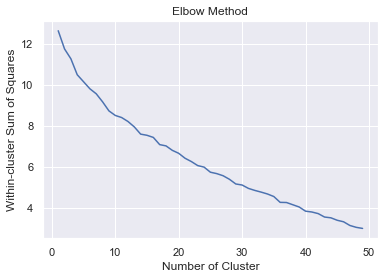

In [17]:
#Extract the returns
returns = all_data[['symbol','return']].copy()
returns['Date'] = returns.index.copy()

#Pivot the returns to create series of returns for each stock 
transposed = returns.pivot(index = 'Date', columns = 'symbol', values = 'return')

#Transpose the data to get companies on the index level and dates on the column level since clusters takes place on index level
X = transposed.dropna().transpose()

#Extract sum of squares for K-means clusters from 1 to 50 clusters
sum_of_sq = np.zeros([50, 1])
for k in range(1, 51):
    sum_of_sq[k-1] = KMeans(n_clusters=k).fit(X).inertia_
    
plt.plot(range(1, 50), sum_of_sq[1:50])
plt.title("Elbow Method") 
plt.xlabel("Number of Cluster") 
plt.ylabel("Within-cluster Sum of Squares")

pd.DataFrame(sum_of_sq, columns = ['Difference in SS'], index = range(1,51)).diff()

In [18]:
#Get 17 clusters
gmm = GaussianMixture(n_components = 17)
gmm.fit(transposed.dropna().transpose())

#Predict for each company
clusters = gmm.predict(transposed.dropna().transpose())
clusters_df = pd.DataFrame({'Cluster':clusters,
                           'Companies':transposed.columns})

#Sort by Clusters
clusters_df = clusters_df.sort_values(['Cluster']).reset_index(drop = True)

#Save as csv
clusters_df.to_csv("clusters.csv")
clusters_df = pd.read_csv("clusters.csv", index_col = 0)

In [19]:
all_data.index = pd.to_datetime(all_data.index)
#print(all_data)

all_data = all_data.sort_index()

train_data = all_data.loc[:'2021-02-24',]
#print(train_data)
test_data = all_data.loc['2021-02-25':]
print(test_data)

                  High         Low        Open       Close      Volume  \
Date                                                                     
2021-02-25  556.479980  535.750000  550.270020  546.700012   4245800.0   
2021-02-25   88.629997   86.889999   88.470001   87.330002   2783000.0   
2021-02-25  266.940002  254.039993  262.299988  254.690002  19001000.0   
2021-02-25  262.970001  253.279999  260.070007  254.220001   1627500.0   
2021-02-25  139.179993  134.529999  137.600006  135.539993   5669500.0   
...                ...         ...         ...         ...         ...   
2021-02-26   15.200000   14.615000   15.160000   14.700000  18381591.0   
2021-02-26   61.020000   58.799999   60.849998   59.310001   5797776.0   
2021-02-26  328.519989  319.073486  325.769989  319.480011   3325986.0   
2021-02-26  335.890015  330.940002  335.510010  331.000000   3139634.0   
2021-02-26   55.055000   53.119999   54.410000   54.369999  32855440.0   

             Adj Close symbol    retu

Text(0.5, 1.0, 'Validation Curve Score for n_estimators')

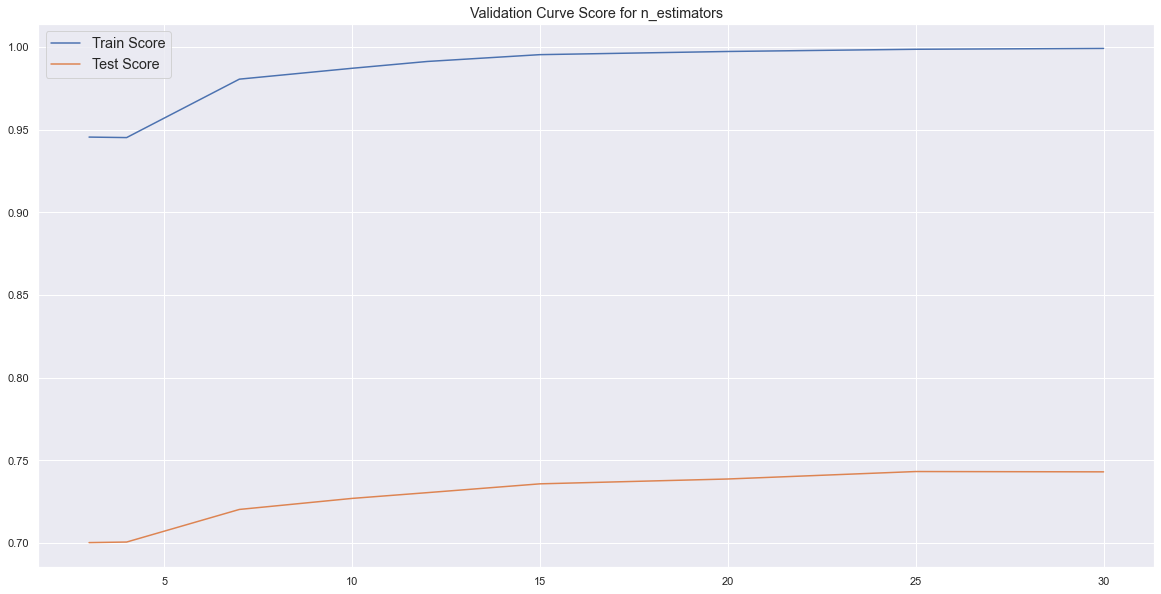

In [20]:
#Separate between X and Y
X_train = train_data.loc[:,Target_variables]

Y_train = train_data.loc[:,['Target_Direction']]

#Create validation curve for the Random Forest Classifier
rf = RandomForestClassifier()
train_scoreNum, test_scoreNum = validation_curve(rf,
                                X = X_train['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'], 
                                param_name = 'n_estimators', 
                                param_range = [3,4,7,10,12,15,20,25,30], cv = TimeSeriesSplit(n_splits = 3))

train_scores_mean = np.mean(train_scoreNum, axis=1)
train_scores_std = np.std(train_scoreNum, axis=1)
test_scores_mean = np.mean(test_scoreNum, axis=1)
test_scores_std = np.std(test_scoreNum, axis=1)

plt.figure(figsize = (20,10))
plt.plot([3,4,7,10,12,15,20,25,30],train_scores_mean)
plt.plot([3,4,7,10,12,15,20,25,30],test_scores_mean)
plt.legend(['Train Score','Test Score'], fontsize = 'large')
plt.title('Validation Curve Score for n_estimators', fontsize = 'large')

In [21]:

#Run the loop for every unique cluster - 17 loops
for cluster_selected in clusters_df.Cluster.unique():
    
    print(f'The current cluster running is : {cluster_selected}')
    
    #Get data for that cluster
    co_data = all_data[all_data.symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
    co_train = co_data[:'2021-02-24']
    co_train = co_train.dropna().copy()
    
    X_train = co_train.loc[:,Target_variables]

    Y_train = co_train.loc[:,['Target_Direction']]

    #Define paramters from Validation Curve
    params = {'max_depth': [5, 7],
          'max_features': ['sqrt'],
          'min_samples_leaf': [10, 15, 20],
          'n_estimators': [5, 7, 9],
         'min_samples_split':[20, 25, 30]} #Using Validation Curves

    rf = RandomForestClassifier()

    #Perform a TimeSeriesSplit on the dataset
    time_series_split = TimeSeriesSplit(n_splits = 3)

    
    rf_cv = GridSearchCV(rf, params, cv = time_series_split, n_jobs = -1, verbose = 20)

    #Fit the random forest with our X_train and Y_train
    rf_cv.fit(X_train, Y_train.values.ravel())
          
    #Save the fited variable into a Pickle file
    file_loc = f'{os.getcwd()}\\Pickle_Files\\Cluster_{cluster_selected}'    
    pickle.dump(rf_cv, open(file_loc,'wb'))
    

The current cluster running is : 0
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 1
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 2
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 3
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 4
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 5
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 6
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 7
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 8
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is : 9
Fitting 3 folds for each of 54 candidates, totalling 162 fits
The current cluster running is

In [22]:
#Use 2nd January Data
day_data = test_data.loc['2021-02-26']

pred_for_tomorrow = pd.DataFrame({'Date':[],
                                  'company':[],
                                  'prediction':[]})

#Predict each stock using the 2nd January Data
for cluster_selected in clusters_df.Cluster.unique():
    rf_cv =  pickle.load(open(os.getcwd() + f'\\Pickle_Files\\Cluster_{cluster_selected}', 'rb'))
    best_rf = rf_cv.best_estimator_
    cluster_data = day_data.loc[day_data.symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
    cluster_data = cluster_data.dropna()
    if (cluster_data.shape[0]>0):
        X_test = cluster_data.loc[:,Target_variables]

        pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
                                                                   'company':cluster_data['symbol'],
                                                                   'prediction':best_rf.predict_proba(X_test)[:,1]}), ignore_index = True)
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(pred_for_tomorrow)

         Date company  prediction
0  2021-02-26     SLB    0.286307
1  2021-02-26     COP    0.322471
2  2021-02-26     CAT    0.281626
3  2021-02-26     EMR    0.292256
4  2021-02-26     UNP    0.231897
5  2021-02-26     FDX    0.512260
6  2021-02-26     KMI    0.214575
7  2021-02-26      PM    0.056451
8  2021-02-26      MO    0.224190
9  2021-02-26      KO    0.055863
10 2021-02-26    MDLZ    0.036870
11 2021-02-26      VZ    0.094120
12 2021-02-26    CHTR    0.556001
13 2021-02-26     PEP    0.084568
14 2021-02-26      PG    0.427076
15 2021-02-26      CL    0.048137
16 2021-02-26     AMT    0.064088
17 2021-02-26     RTX    0.070236
18 2021-02-26       F    0.321659
19 2021-02-26      GM    0.470110
20 2021-02-26       C    0.198331
21 2021-02-26     CVX    0.266928
22 2021-02-26      MS    0.224958
23 2021-02-26     AXP    0.312078
24 2021-02-26     MET    0.344691
25 2021-02-26     WFC    0.211421
26 2021-02-26      GE    0.312727
27 2021-02-26     USB    0.177441
28 2021-02-26 

In [23]:
top_10_pred = pred_for_tomorrow.sort_values(by = ['prediction'], ascending = False).head(10)

for selected_company in top_10_pred['company']:
    actual = all_data[all_data.symbol == selected_company].loc['2021-02-26','Target_Direction']
    pct_change = all_data[all_data.symbol == selected_company].loc['2021-02-26','Target']
    top_10_pred.loc[top_10_pred.company == selected_company,'actual'] = actual
    top_10_pred.loc[top_10_pred.company == selected_company,'pct_change'] = pct_change
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(top_10_pred)

         Date company  prediction  actual  pct_change
45 2021-02-26    SBUX    0.879054     1.0    3.725393
51 2021-02-26    MSFT    0.684235     1.0    0.369295
71 2021-02-26     LLY    0.631415     0.0   -0.875664
85 2021-02-26    NVDA    0.630416     0.0   -0.276306
49 2021-02-26    ADBE    0.622639     0.0   -0.677387
44 2021-02-26    GOOG    0.622535     0.0   -0.666174
53 2021-02-26    TSLA    0.580104     0.0   -3.500000
86 2021-02-26     TXN    0.577079     0.0   -0.582868
78 2021-02-26      DD    0.575517     1.0    0.629654
12 2021-02-26    CHTR    0.556001     1.0    1.814137
